# A Brief Explanation of Gaussian Mixture Models (and how to use this one)

This notebook provides a demonstration of the GMM class on preprocessed real Netflix user data as well as a presentation of the mathematics used in constructing the class. The GMM class is my implementation of a popular unsupervised machine learning model known as a _Gaussian mixture model_. Roughly speaking this kind of model assumes that the data was generated by a weighted combination of Gaussian distributions. Future additions to this project will include testing the model on the original much larger Netflix user data set as well as discussions of how to prepare that data for the model.

### The Log Likelihood Function

Once you've made your assumptions on the KIND of statistical model you'd like to employ (in this case a Gaussian mixture model) it's common practice to search for valid model parameters by maximizing the _likelihood function_ associated with that model. The likelihood function is a function of the parameters that provides a measure on the plausibility that those parameters generated the observed data. Our task is to find parameter values that make this function as large as possible. It's often mathematically simpler to work with the natural logarithm of the likelihood and so we will do that here.

The model expects data to be stored as two dimensional Numpy arrays of integer values 0 thru 5. In the case of our netflix example each row and column represents a user and movie respectively. The entry in the $u$th row and $j$th column represents the rating (from 1-5) that user $u$ gave to movie $j$. An entry of 0 means the movie hasn't been reviewed by that user. Specifically we will interpret each row of the input matrix (each user's ratings vector) as a data point generated by a spherical Gaussian mixture model. By 'spherical' we mean that each cluster's variance is the same along every dimension. Without further ado, let $\pi$, $\mu$, and $\sigma$ denote the cluster weights and the means and variances of each cluster respectively. Our task is then to fine tune these parameters to maximize the following _log likelihood function_ :

## $$ \ell(X, \theta) = \sum_{u=1}^{n} \log \left( \sum_{j=1}^{K} \pi_j \mathcal{N}(x_{C_u}^{(u)} | \mu_{C_u}^{(j)}, \sigma_j^2I_{|C_u| \times |C_u|}) \right) $$

There's a lot of notation to unpack here. $X$ represents the matrix of ratings vectors of all users and $\theta$ just conveniently collects all of the model parameters $\pi$, $\mu$, and $\sigma^2$ into a single variable. $K$ represents the number of clusters, $x^{(u)}$ represents the ratings vector of the $u$th user (i.e. $u$th row of $X$), and $C_u$ represents a one-hot vector with the same dimension as $x^{(u)}$ that is $1$ where the $u$th user has rated a movie and zero otherwise. We subscript a vector with $C_u$ to represent removing all of its zero values, i.e. if $x=(1,2,0,4)$ then $C_u = (1,1,0,1)$ and $x_{C_u} = (1,2,4)$. We use $|C_u|$ to denote the number of nonzero values in $C_u$. Finally, we have the _Gaussian probability density function_ for a spherical gaussian random vector with dimension $d$, mean $\mu$, and variance $\sigma^2$ given by:

## $$ \mathcal{N}(x| \mu, \sigma^2I_{d\times d}) = \frac{1}{(2\pi \sigma^2)^{\frac{d}{2}}} \exp\left( -\frac{1}{2\sigma^2} \|x - \mu \|^2 \right)$$

In our case $d = |C_u|$. 

### EM algorithm: How and Why

We may wish to use the _maximum likelihood estimator_ (MLE) to estimate the parameters $\theta$ which would involve optimizing the log likelihood using calculus. However this is far too mathematically and computationally expensive for the current model. Enter the _Expectation Maximization algorithm_ , an algorithm that in our case will iteratively compute the _posterior distribution_ for the parameters given the observed data and then select new parameters to maximize this quantity.

One function of the algorithm is to _softly assign_ a data point $u$ to cluster $j$ which means a weighted assignment mixed among the different clusters. We can do this with an application of Bayes' rule. Handwaving away the details we end up with an expression for the probability of cluster $j$ being the generating cluster given the observed data point $u$:

## $$P(j|u) = \frac{\pi_j \mathcal{N}(x_{C_u}^{(u)} | \mu_{C_u}^{(j)}, \sigma_j^2I_{|C_u| \times |C_u|})}{\sum_{j=1}^{K} \pi_j \mathcal{N}(x_{C_u}^{(u)} | \mu_{C_u}^{(j)}, \sigma_j^2I_{|C_u| \times |C_u|}) }$$

The Maximization step then selects new parameters to maximize this quantity according to the following rules:

### $$ \hat{\pi}_j = \frac{\sum_{u=1}^{n} P(j|u)}{n}$$

### $$ \hat{\mu}^{(j)}_l = \frac{\sum_{u=1}^{n} \delta(l, C_u) P(j|u)x^{(u)}_l}{\sum_{u=1}^{n} \delta(l,C_u)P(j|u)}$$

### $$ \hat{\sigma}^2_j = \frac{\sum_{u=1}^{n}P(j|u) \|x^{(u)}_{C_u} - \hat{u}^{(j)}_{C_u} \|^2}{\sum_{u=1}^{n} |C_u|P(j|u)} $$

We are updating the weight associated with the $j$th cluster, then the $l$th component of the mean vector associated with the $j$th cluster, and finally the variance associated with the $j$th cluster. Here $\delta(l, C_u)$ denotes an indicator function that is equal to $1$ if $l \in C_u$ and $0$ otherwise. An efficient implementation of the EM algorithm will involve collecting these update rules into matrix operations so that all operations on the data can be vectorized.

### Running the Model

In [1]:
from gaussian_mixture import GMM
import numpy as np

The model doesn't need a completed matrix for training, which is why it works for matrix completion (and why we used $C_u$ above). However we'll showcase its versatility by first training on a completed matrix. Then we'll use it to fill the incomplete and totally empty versions and then use the model's evaluate_rmse method to compute the root mean square error of the results.

In [2]:
X_incomplete = np.loadtxt('netflix_incomplete.txt')
X_complete = np.loadtxt('netflix_complete.txt')
X_empty = np.zeros(X_incomplete.shape)
X_empty.shape

(1200, 1200)

Our input to the model represents 1200 users each reviewing a subset of 1200 movies. Note that the matrix does not need to be square. Now let's create an instance of the model with 12 clusters and random initialization seed 1. Note that we must pass the training matrix to the constructor.

In [3]:
g = GMM(X_complete, 12, 1)

The run method has one hyperparameter, 'min_variance' which serves as a lower bound on what the variance parameter can be updated to by the EM algorithm. This is a crude way to avoid the vanishing variance problem. Also, the run method stops by checking how close the updated log likelihood is to the old log likelihood. Once the distance between them is small enough in comparison to the new log likelihood, the EM algorithm completes. If the model implemented a maximum number of EM steps then this condition would be referred to as _early stopping_.

In [4]:
g.run(min_variance=.1)

Once the model has been run, we can use the fill_matrix method to complete matrices using the trained parameters simply by passing in the matrix to fill.

In [5]:
empty_filled = g.fill_matrix(X_empty)
incomplete_filled = g.fill_matrix(X_incomplete)

In [6]:
g.evaluate_rmse(empty_filled, X_complete)

0.8278160903239833

In [7]:
g.evaluate_rmse(incomplete_filled, X_complete)

0.3381901627344693

Unsurprisingly the model produces a lower root mean square error when filling a partially completed matrix as opposed to a completely empty one. However in either case the model is performing quite well by averaging less than 1 point away from the correct review when the scale is 1-5. Let's view the history of the log likelihood which should hopefully be increasing over time:

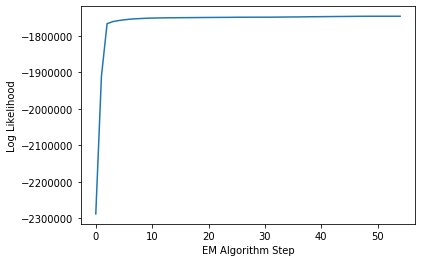

In [8]:
g.plot_history()

Indeed, we see what we expect. However it's obviously not realistic to expect that every user has rated every movie. So let's train on more realistic data (in fact actually real data). Note that we must create a new instance of the GMM class because the training matrix is passed as an argument to the constructor.

In [9]:
g2 = GMM(X_incomplete, 12, 1)
g2.run(min_variance=.1)

In [10]:
empty_filled = g2.fill_matrix(X_empty)
incomplete_filled = g2.fill_matrix(X_incomplete)

In [11]:
g2.evaluate_rmse(empty_filled, X_complete)

0.8877916341072648

In [12]:
g2.evaluate_rmse(incomplete_filled, X_complete)

0.48258643551072883

Indeed the performance is similarly good even when the data is incomplete as would be the case in a more realistic setting. Let's check that the log likelihood increased as the algorithm progressed.

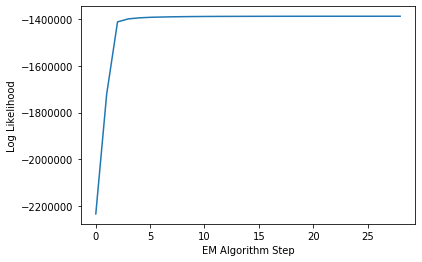

In [13]:
g2.plot_history()